In [438]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 连接数据库

In [439]:
conn = sqlite3.connect("academic_ranking.db")

## 使用pandas方便地查询和展示数据

In [ ]:
def sql2pd(sql):
    return pd.read_sql_query(sql, conn) # 将sql查询结果转换为DataFrame

## 3. 华东师范大学在各个学科中的排名


In [443]:
ecnu_ranking = sql2pd("""
    SELECT DISTINCT
        f.field_name AS 学科,           -- 学科名称
        r.rank_position AS 排名,        -- 排名
        r.wos_documents AS 文献数,       -- 文献数
        r.cites AS 引用数,               -- 引用数
        r.cites_per_paper AS 篇均引用,   -- 篇均引用
        r.top_papers AS 顶级论文数       -- 顶级论文数
    FROM ranking_data r                 -- 从ranking_data表中选择数据
    JOIN institutions i ON r.institution_id = i.institution_id  -- 连接institutions表
    JOIN research_fields f ON r.field_id = f.field_id           -- 连接research_fields表
    WHERE i.institution_name LIKE '%EAST CHINA NORMAL%'         -- 筛选华东师范大学
    ORDER BY r.rank_position            -- 按排名升序
""")
print(f"华东师范大学共进入{len(ecnu_ranking)}个学科排名")
ecnu_ranking

华东师范大学共进入17个学科排名


,学科,排名,文献数,引用数,篇均引用,顶级论文数
0,Chemistry,90,5420,164390,30.33,157
1,Mathematics,115,2019,11984,5.94,22
2,Environment Ecology,130,2941,92088,31.31,101
3,Materials Science,196,2720,93969,34.55,57
4,Computer Science,207,1803,22336,12.39,25
5,Geosciences,275,1850,42158,22.79,38
6,"Social Sciences, General",314,2176,27524,12.65,51
7,Engineering,317,2567,55450,21.60,86
8,Plant & Animal Science,395,1375,21843,15.89,26
9,Psychiatry Psychology,467,1460,15243,10.44,7


## 4. 中国（大陆地区）大学在各个学科中的表现

#### 4.1. 按上榜机构数排名

In [444]:
china_performance = sql2pd("""
    SELECT 
        f.field_name AS 学科,                           -- 学科名称
        COUNT(*) AS 上榜机构数,                          -- 上榜机构数
        SUM(r.wos_documents) AS 文献数,                 -- 总文献数
        SUM(r.cites) AS 引用数,                         -- 总引用数
        ROUND(AVG(r.cites_per_paper), 2) AS 篇均引用,    -- 篇均引用
        SUM(r.top_papers) AS 顶级论文数                  -- 顶级论文数
    FROM ranking_data r                                         -- 从ranking_data表中选择数据
    JOIN institutions i ON r.institution_id = i.institution_id  -- 连接institutions表
    JOIN research_fields f ON r.field_id = f.field_id           -- 连接research_fields表
    WHERE i.is_chinese_mainland = 1                             -- 仅筛选中国大陆机构
    GROUP BY f.field_name                                       -- 按学科分组
    ORDER BY 上榜机构数 DESC                              -- 按机构数量降序排列
""")
print(f"中国大陆共在{len(china_performance)}个学科中有机构上榜")
china_performance

中国大陆共在22个学科中有机构上榜


,学科,上榜机构数,文献数,引用数,篇均引用,顶级论文数
0,Engineering,534,1503716,24966306,17.14,24675
1,Chemistry,423,1249235,30165345,21.43,26271
2,Materials Science,375,1119272,32354021,26.40,21769
3,Environment Ecology,337,489374,11317663,22.54,9594
4,Clinical Medicine,259,972240,16535599,26.10,15613
5,Agricultural Sciences,251,274214,5080975,17.75,4615
6,Plant & Animal Science,248,313104,5066265,16.09,7763
7,Biology & Biochemistry,206,310748,6218009,20.90,4173
8,Computer Science,190,325041,5330017,17.07,5882
9,Pharmacology & Toxicology,182,217471,3502876,16.15,2556


#### 4.2. 各学科进入全球前10/50/100名的机构数量

In [445]:
# 统计中国大陆各学科进入全球前10/50/100名的机构数量
china_topN = sql2pd("""
    SELECT
        f.field_name AS 学科,
        SUM(CASE WHEN r.rank_position <= 10 THEN 1 ELSE 0 END) AS 前10,     -- 计算进入全球前10的机构数量和
        SUM(CASE WHEN r.rank_position <= 50 THEN 1 ELSE 0 END) AS 前50,     -- 计算进入全球前50的机构数量和
        SUM(CASE WHEN r.rank_position <= 100 THEN 1 ELSE 0 END) AS 前100    -- 计算进入全球前100的机构数量和
    FROM ranking_data r                                          -- 从ranking_data表中查询
    JOIN institutions i ON r.institution_id = i.institution_id   -- 连接institutions表
    JOIN research_fields f ON r.field_id = f.field_id            -- 连接research_fields表
    WHERE i.is_chinese_mainland = 1                              -- 只统计中国大陆机构
    GROUP BY f.field_name                                        -- 按学科分组
    ORDER BY 前10 DESC                                           -- 以前10数量排名
""")
print("各学科中国大陆机构进入全球前10/50/100排行榜数量")
china_topN

各学科中国大陆机构进入全球前10/50/100排行榜数量


,学科,前10,前50,前100
0,Materials Science,6,32,48
1,Agricultural Sciences,6,15,22
2,Engineering,5,29,46
3,Computer Science,5,25,44
4,Chemistry,4,27,46
5,Plant & Animal Science,3,8,13
6,Geosciences,3,12,22
7,Environment Ecology,3,9,14
8,Physics,1,7,10
9,Pharmacology & Toxicology,1,17,29


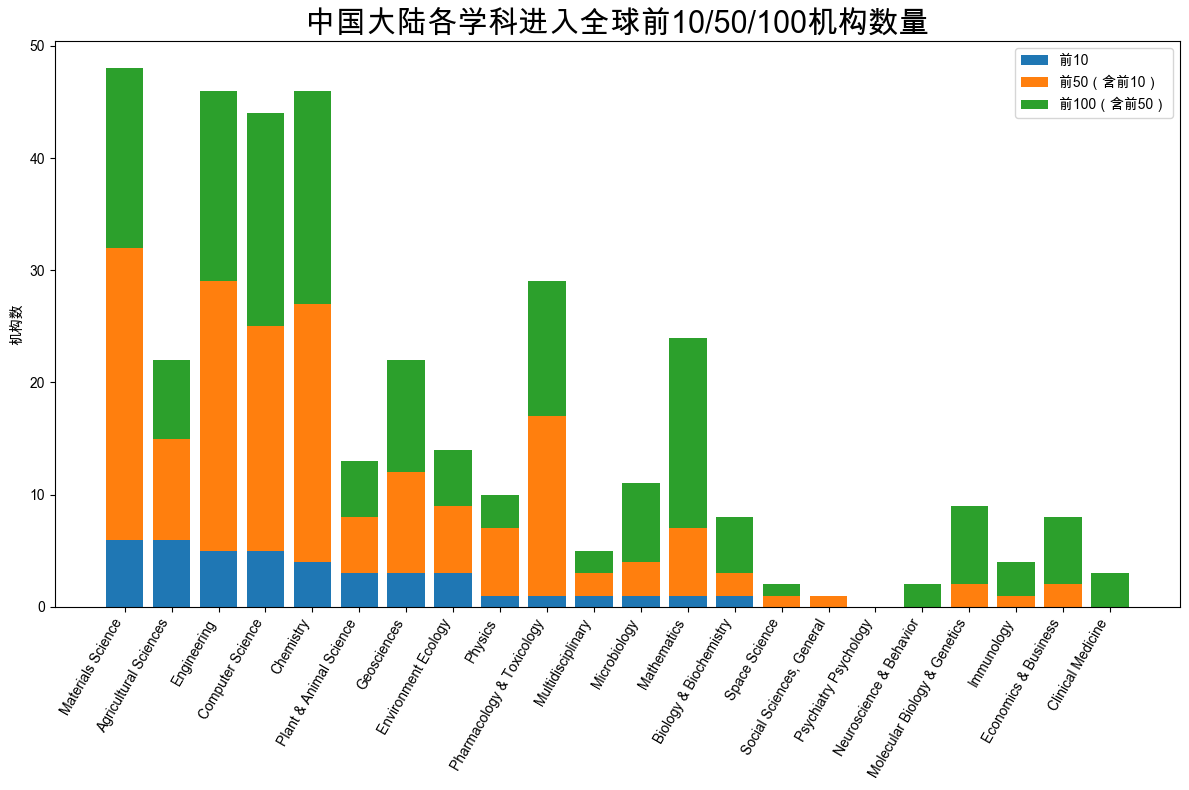

In [ ]:
# 可视化
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(15, 8))
x = china_topN["学科"]
bar1 = ax.bar(x, china_topN["前10"], label="前10")
bar2 = ax.bar(x, china_topN["前50"], bottom=china_topN["前10"], label="前50（含前10）")
prev_sum = china_topN["前50"]
add_sum = china_topN["前100"] - china_topN["前50"]
bar3 = ax.bar(x, add_sum, bottom=prev_sum, label="前100（含前50）")
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=60, ha="right")
ax.set_ylabel("机构数")
ax.set_title("中国大陆各学科进入全球前10/50/100机构数量", fontsize=22)
ax.legend()
plt.tight_layout()
plt.show()

## 5. 全球不同区域在各个学科中的表现

In [447]:
# 划分区域
REGION_STR = """
CASE 
    WHEN i.country_region = 'CHINA MAINLAND' THEN '中国大陆'
    WHEN i.country_region IN (
        'USA', 'CANADA', 'MEXICO'
    ) THEN '北美'
    WHEN i.country_region IN (
        'ENGLAND', 'GERMANY (FED REP GER)', 'FRANCE', 'NETHERLANDS', 
        'SWITZERLAND', 'ITALY', 'SPAIN', 'SWEDEN', 'BELGIUM', 
        'AUSTRIA', 'DENMARK', 'FINLAND', 'NORWAY', 'IRELAND', 'PORTUGAL', 'POLAND', 
        'HUNGARY', 'CZECH REPUBLIC', 'GREECE', 'RUSSIA', 'SLOVENIA'
    ) THEN '欧洲'
    WHEN i.country_region IN (
        'JAPAN', 'SOUTH KOREA', 'SINGAPORE', 'INDIA', 'VIETNAM',
        'THAILAND', 'PHILIPPINES', 'INDONESIA', 'PAKISTAN', 
        'BANGLADESH', 'SRI LANKA', 'TAIWAN', 'HONG KONG', 'MALAYSIA', 
        'MACAU', 'ISRAEL', 'SAUDI ARABIA', 'IRAN', 'TURKEY', 'QATAR', 'UNITED ARAB EMIRATES'
    ) THEN '亚洲其他'
    WHEN i.country_region IN (
        'AUSTRALIA', 'NEW ZEALAND'
    ) THEN '大洋洲'
    WHEN i.country_region IN (
        'BRAZIL', 'ARGENTINA', 'CHILE', 'COLOMBIA', 'PERU', 
        'URUGUAY', 'VENEZUELA', 'ECUADOR', 'BOLIVIA', 'PARAGUAY'
    ) THEN '南美'
    WHEN i.country_region IN (
        'SOUTH AFRICA', 'EGYPT', 'NIGERIA', 'KENYA', 'MOROCCO', 
        'ETHIOPIA', 'ALGERIA', 'GHANA', 'TUNISIA', 'TANZANIA'
    ) THEN '非洲'
    ELSE '其他'
"""

#### 5.1. 按上榜机构数排名

In [448]:
# 按地理区域划分并分析表现
region_performance = sql2pd("""
    SELECT 
        f.field_name AS 学科, 
        """ + REGION_STR + 
        """
        END AS 区域,
        COUNT(*) AS 机构数,                             -- 该区域内机构数
        SUM(r.wos_documents) AS 文献数,                 -- 该区域内文献总数
        SUM(r.cites) AS 引用数,                         -- 该区域内引用总数
        ROUND(AVG(r.cites_per_paper), 2) AS 篇均引用,   -- 该区域内篇均引用
        SUM(r.top_papers) AS 顶级论文数                 -- 该区域内顶级论文数
    FROM ranking_data r
    JOIN institutions i ON r.institution_id = i.institution_id -- 关联机构表
    JOIN research_fields f ON r.field_id = f.field_id          -- 关联学科表
    GROUP BY f.field_name, 区域                         -- 按学科和区域分组
    ORDER BY f.field_name, 机构数 DESC                  -- 按学科排序、区域机构数降序
""")
region_performance

,学科,区域,机构数,文献数,引用数,篇均引用,顶级论文数
0,Agricultural Sciences,欧洲,427,301154,6317941,21.82,4525
1,Agricultural Sciences,中国大陆,251,274214,5080975,17.75,4615
2,Agricultural Sciences,北美,213,206958,4048060,21.76,3065
3,Agricultural Sciences,亚洲其他,201,145518,2174148,16.62,1615
4,Agricultural Sciences,其他,115,57003,1026449,21.69,775
...,...,...,...,...,...,...,...
171,Space Science,中国大陆,10,45825,993908,23.75,778
172,Space Science,大洋洲,9,17648,715001,40.80,685
173,Space Science,其他,7,17844,821890,51.54,773
174,Space Science,南美,4,11871,446086,37.51,340


#### 5.2. 各区域在前100名中的机构数量

In [449]:
top_n = 100

region_topN_performance = sql2pd(f"""
    SELECT 
        f.field_name AS 学科, {REGION_STR}
        END AS 区域,
        COUNT(*) AS 机构数
    FROM ranking_data r                                        -- 从ranking_data表中查询
    JOIN institutions i ON r.institution_id = i.institution_id -- 连接institutions表
    JOIN research_fields f ON r.field_id = f.field_id          -- 连接research_fields表
    WHERE r.rank_position <= {top_n}                           -- 只统计前100名机构
    GROUP BY f.field_name, 区域                                 -- 按学科和区域分组
""")

# 图表显示顺序
region_order = [
    '中国大陆','北美','欧洲','亚洲其他','大洋洲','南美','非洲','其他'
]

region_topn_pivot = region_topN_performance.pivot_table(
    index='学科',
    columns='区域', 
    values='机构数',
    fill_value=0
).astype(int)

# “其他”放在最后一列
cols_sorted = [col for col in region_order if col in region_topn_pivot.columns]
region_topn_pivot = region_topn_pivot.reindex(columns=cols_sorted)

# region_topn_pivot

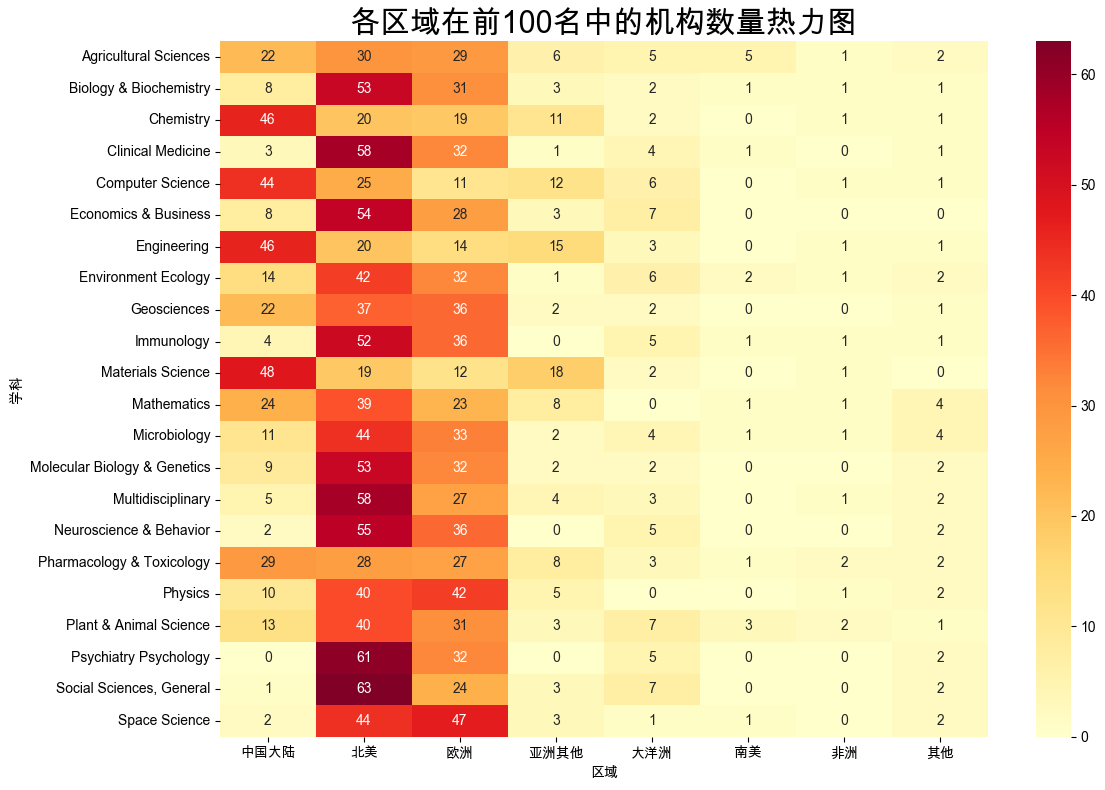

In [453]:
# 可视化
plt.figure(figsize=(12, 8))
sns.heatmap(region_topn_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title(f"各区域在前{top_n}名中的机构数量热力图", fontsize=22)
plt.xlabel("区域")
plt.ylabel("学科")
plt.tight_layout()
plt.show()

## 关闭数据库连接


In [451]:
conn.close()
print("数据库连接已关闭")

数据库连接已关闭
